In [ ]:
# Install library yang diperlukan
!pip install tensorflow scikit-learn matplotlib

import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.models import Model
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import cv2
from skimage.feature import hog
from sklearn.tree import DecisionTreeClassifier

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path_acne = '/content/drive/MyDrive/PDM/BIASA/train/acne'
path_eksim = '/content/drive/MyDrive/PDM/BIASA/train/eksim'
path_herpes = '/content/drive/MyDrive/PDM/BIASA/train/herpes'
path_panu = '/content/drive/MyDrive/PDM/BIASA/train/panu'
path_rosacea = '/content/drive/MyDrive/PDM/BIASA/train/rosacea'

image augmentation

In [ ]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,     # membagi dataset menjadi dua bagian
    rotation_range=30,        # Rotasi gambar hingga 40 derajat
    width_shift_range=0.2,    # Geser gambar secara horizontal
    height_shift_range=0.2,   # Geser gambar secara vertikal
    shear_range=0.2,          # Shear transformation
    zoom_range=0.2,           # Zoom in/out
    horizontal_flip=True,     # Membalik gambar secara horizontal
    fill_mode='nearest',      # Mengisi pixel yang hilang

)


load data dari direktori

In [ ]:
 # Data pelatihan
train_data = datagen.flow_from_directory(
    directory='/content/drive/MyDrive/PDM/BIASA/train',
    classes=['acne', 'eksim', 'herpes','panu','rosacea'],  # Menentukan kelas
    target_size=(128, 128),  # Ukuran gambar
    batch_size=32,  # Jumlah gambar dalam setiap batch
    class_mode='binary',  # Klasifikasi biner
    subset='training'  # Subset data pelatihan
)

# Data validasi
valid_data = datagen.flow_from_directory(
    directory='/content/drive/MyDrive/PDM/BIASA/train',
    classes=['acne', 'eksim', 'herpes','panu','rosacea'],  # Menentukan kelas
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='validation'  # Subset data validasi
)

# Menampilkan kelas dan label
print(train_data.class_indices)

Found 328 images belonging to 5 classes.
Found 80 images belonging to 5 classes.
{'acne': 0, 'eksim': 1, 'herpes': 2, 'panu': 3, 'rosacea': 4}


visualisasi **data**

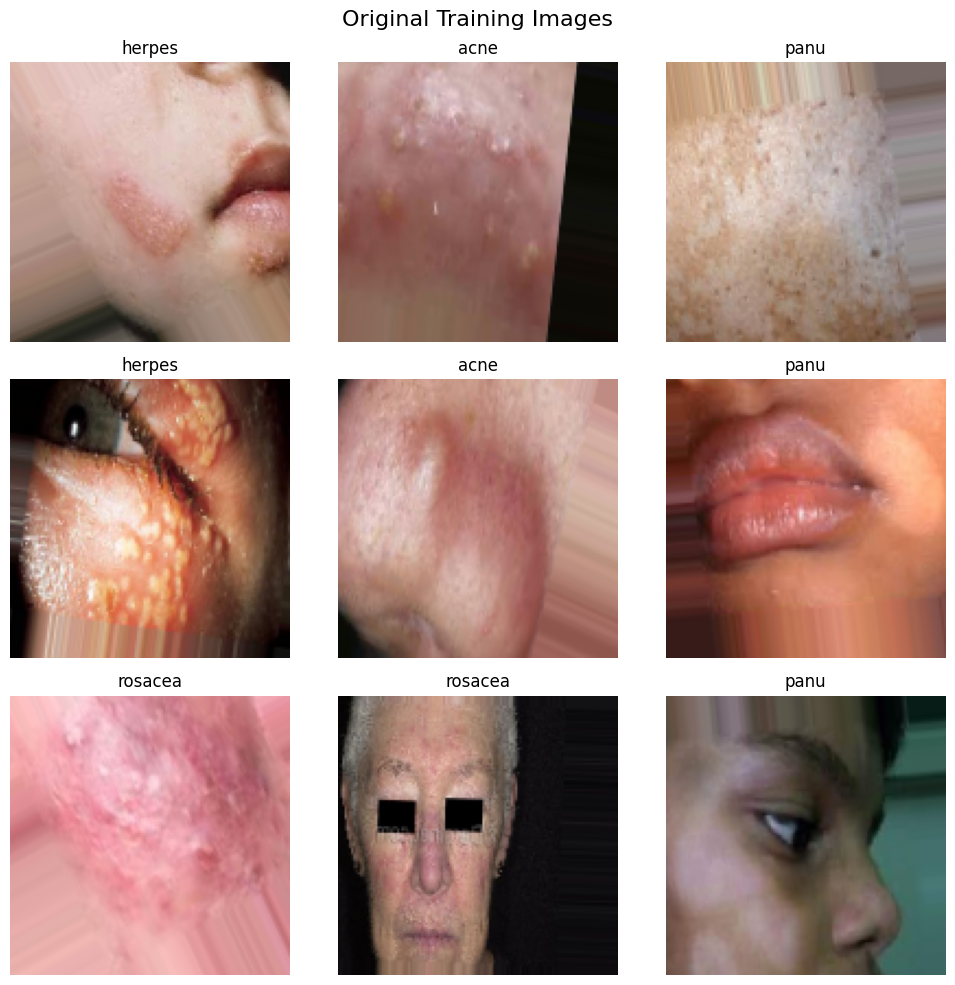

In [ ]:
# Ambil batch pertama dari original_data
images, labels = next(train_data)

# Daftar nama kelas
class_names = ['acne', 'eksim ', 'herpes','panu','rosacea']

# Visualisasi gambar asli dari train set
plt.figure(figsize=(10, 10))
for i in range(9):  # Menampilkan 9 gambar pertama
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])  # Gambar asli
    label_index = int(labels[i])  # Pastikan index dalam bentuk integer
    plt.title(class_names[label_index])  # Menampilkan nama kelas
    plt.axis('off')

plt.suptitle("Original Training Images", fontsize=16)
plt.tight_layout()
plt.show()


cek jumlah sampel

In [ ]:
# Menampilkan jumlah sampel dalam subset training dan validation
print("Jumlah sampel dalam data pelatihan:", train_data.samples)
print("Jumlah sampel dalam data validasi:", valid_data.samples)

Jumlah sampel dalam data pelatihan: 328
Jumlah sampel dalam data validasi: 80


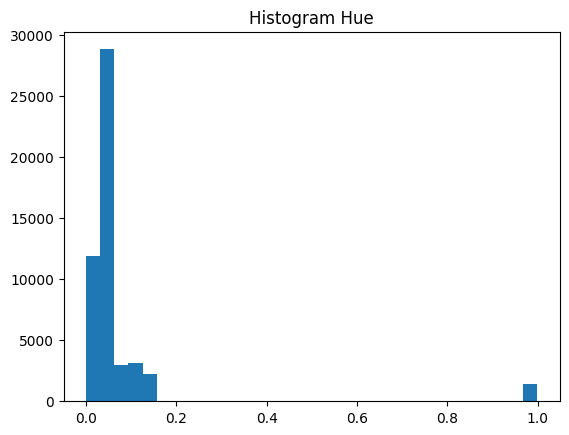

In [ ]:
from skimage import io, color
# Ambil satu gambar dari dataset
image_path = '/content/drive/MyDrive/PDM/BIASA/train/eksim/ek79_jpg.rf.32bb4ec9540923ab29a0beed766ad14f.jpg'  # Ganti dengan path gambar Anda
image = io.imread(image_path)

# Konversi ke ruang warna HSV
hsv_image = color.rgb2hsv(image)

# Hitung histogram untuk saluran Hue (warna)
plt.hist(hsv_image[:, :, 0].ravel(), bins=32)
plt.title('Histogram Hue')
plt.show()

In [ ]:
from skimage.feature import graycomatrix, graycoprops

# Konversi gambar ke grayscale
gray_image = color.rgb2gray(image)

# Konversi gambar grayscale ke tipe data unsigned integer 8-bit
gray_image = (gray_image * 255).astype(np.uint8) # Mengubah tipe data gambar grayscale

# Hitung GLCM
glcm = graycomatrix(gray_image, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)

# Hitung fitur tekstur (misal: contrast)
contrast = graycoprops(glcm, 'contrast')[0, 0]
print(f"Contrast: {contrast}")

Contrast: 28.819862211368562


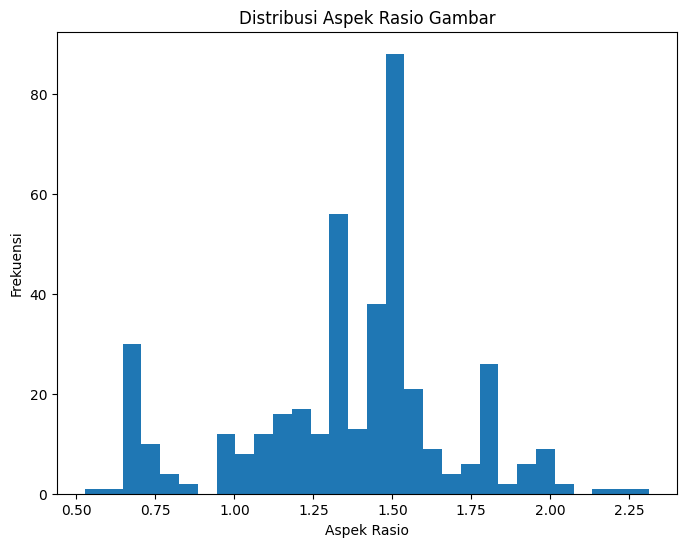

Aspek rasio rata-rata: 1.37
Aspek rasio standar deviasi: 0.33


In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Path ke direktori dataset
dataset_path = '/content/drive/MyDrive/PDM/BIASA/train'

# Inisialisasi list untuk menyimpan aspek rasio gambar
aspect_ratios = []

# Iterasi melalui semua gambar dalam dataset
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    for image_file in os.listdir(class_path):
        image_path = os.path.join(class_path, image_file)
        with Image.open(image_path) as img:
            width, height = img.size
            aspect_ratios.append(width / height)

# Visualisasi distribusi aspek rasio gambar
plt.figure(figsize=(8, 6))
plt.hist(aspect_ratios, bins=30)
plt.title('Distribusi Aspek Rasio Gambar')
plt.xlabel('Aspek Rasio')
plt.ylabel('Frekuensi')
plt.show()

# Menampilkan statistik aspek rasio gambar
print(f"Aspek rasio rata-rata: {np.mean(aspect_ratios):.2f}")
print(f"Aspek rasio standar deviasi: {np.std(aspect_ratios):.2f}")

### **# seleksi fitur**

In [ ]:
#seleksi fitur menggunakan metode univariate selection
selector = SelectKBest(score_func=f_classif, k=20)
selected_features = selector.fit_transform(features, labels)

In [ ]:
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_classif

# Misalnya features adalah DataFrame
selector = SelectKBest(score_func=f_classif, k=20)
selector.fit(features, labels)

# Dapatkan mask fitur yang terpilih
mask = selector.get_support()

# Indeks fitur yang terpilih
selected_feature_indices = np.where(mask)[0]

print("Fitur yang terpilih (indeks):")
print(selected_feature_indices)

Fitur yang terpilih (indeks):
[ 106  119  175  291  422  424  455  513  534  558  603  773  806  852
  880 1014 1024 1098 1122 1152]


#Modeling

In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(selected_features, labels, test_size=0.2, random_state=42)

# Inisialisasi dan latih model
model = GaussianNB()
model.fit(X_train, y_train)

# Prediksi dan evaluasi
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.5975609756097561
Classification Report:
               precision    recall  f1-score   support

           0       0.84      1.00      0.91        16
           1       0.20      0.12      0.15        16
           2       0.47      0.53      0.50        15
           3       0.82      0.82      0.82        17
           4       0.47      0.50      0.49        18

    accuracy                           0.60        82
   macro avg       0.56      0.60      0.58        82
weighted avg       0.56      0.60      0.58        82



In [ ]:
import joblib

# Simpan model ke dalam file
joblib.dump(model, 'modelGNB_kondisi_kulit.pkl')
print("Model telah disimpan.")


Model telah disimpan.


## Meningkatkan augmentasi data

### Subtask:
Sesuaikan parameter `ImageDataGenerator` untuk augmentasi yang lebih efektif atau pertimbangkan teknik augmentasi lainnya.


**Reasoning**:
Modify the ImageDataGenerator parameters for more effective augmentation as instructed.



In [ ]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=40,      # Increased rotation
    width_shift_range=0.25, # Increased shift range
    height_shift_range=0.25,# Increased shift range
    shear_range=0.25,       # Increased shear
    zoom_range=0.25,        # Increased zoom
    horizontal_flip=True,
    fill_mode='reflect',    # Changed fill mode
    brightness_range=[0.8, 1.2] # Added brightness augmentation
)

# Data pelatihan
train_data = datagen.flow_from_directory(
    directory='/content/drive/MyDrive/PDM/BIASA/train',
    classes=['acne', 'eksim', 'herpes','panu','rosacea'],
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

# Data validasi
valid_data = datagen.flow_from_directory(
    directory='/content/drive/MyDrive/PDM/BIASA/train',
    classes=['acne', 'eksim', 'herpes','panu','rosacea'],
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

print(train_data.class_indices)

Found 328 images belonging to 5 classes.
Found 80 images belonging to 5 classes.
{'acne': 0, 'eksim': 1, 'herpes': 2, 'panu': 3, 'rosacea': 4}


## Eksplorasi metode ekstraksi fitur lain

### Subtask:
Coba metode ekstraksi fitur lain selain HOG dan MobileNetV2, atau gabungkan fitur dari beberapa metode.


**Reasoning**:
Implement a function to extract GLCM features from images and then extract these features for all images in the dataset.



In [ ]:
def extract_glcm_features(image_path):
    image = cv2.imread(image_path)
    # Konversi ke grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Resize gambar menjadi ukuran tetap (misalnya 128x128)
    gray_image_resized = cv2.resize(gray_image, (128, 128))
    # Konversi ke tipe data unsigned integer 8-bit
    gray_image_resized = (gray_image_resized).astype(np.uint8)

    # Hitung GLCM
    # Menggunakan jarak 1 dan sudut 0, 45, 90, 135 derajat
    glcm = graycomatrix(gray_image_resized, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256, symmetric=True, normed=True)

    # Hitung fitur tekstur
    contrast = graycoprops(glcm, 'contrast')
    dissimilarity = graycoprops(glcm, 'dissimilarity')
    homogeneity = graycoprops(glcm, 'homogeneity')
    energy = graycoprops(glcm, 'energy')
    correlation = graycoprops(glcm, 'correlation')
    ASM = graycoprops(glcm, 'ASM')

    # Gabungkan fitur dari semua sudut
    glcm_features = np.hstack([contrast, dissimilarity, homogeneity, energy, correlation, ASM])
    return glcm_features.flatten()

# Ekstraksi fitur GLCM untuk setiap gambar
glcm_features = [extract_glcm_features(img) for img in image_paths]
glcm_features = np.array(glcm_features)

In [ ]:
# Regenerate MobileNetV2 features using the same image paths
mobilenet_features = []
for img_path in image_paths:
    image = Image.open(img_path).convert('RGB') # Ensure image is in RGB
    image = image.resize((224, 224))
    image = np.array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    feature = base_model.predict(image)
    mobilenet_features.append(feature.flatten())

mobilenet_features = np.array(mobilenet_features)

# Gabungkan fitur HOG, MobileNetV2, dan GLCM
# Ensure the order of features and labels is consistent
combined_features = np.concatenate((features, mobilenet_features, glcm_features), axis=1)

# Membagi data gabungan menjadi train dan test
X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(combined_features, labels_numeric, test_size=0.2, random_state=42)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━

In [ ]:
# Perform feature selection on the combined features
# Using SelectKBest with f_classif as before, choose a suitable number of features
selector_combined = SelectKBest(score_func=f_classif, k=100) # Example: selecting top 100 features
selected_features_combined = selector_combined.fit_transform(combined_features, labels_numeric)

# Split the selected combined features and labels into training and testing sets
X_train_selected_combined, X_test_selected_combined, y_train_selected_combined, y_test_selected_combined = train_test_split(selected_features_combined, labels_numeric, test_size=0.2, random_state=42)

# Save the combined selected features and labels
np.save('X_train_selected_combined.npy', X_train_selected_combined)
np.save('X_test_selected_combined.npy', X_test_selected_combined)
np.save('y_train_selected_combined.npy', y_train_selected_combined)
np.save('y_test_selected_combined.npy', y_test_selected_combined)

print("Combined selected features and labels saved.")

Combined selected features and labels saved.


## Penyempurnaan seleksi fitur

### Subtask:
Eksplorasi metode seleksi fitur yang berbeda atau sesuaikan parameter `SelectKBest`.


In [ ]:
X_train_combined = np.load('X_train_selected_combined.npy')
X_test_combined = np.load('X_test_selected_combined.npy')
y_train_combined = np.load('y_train_selected_combined.npy')
y_test_combined = np.load('y_test_selected_combined.npy')

print("Combined features and labels loaded.")
print("Shape of X_train_combined:", X_train_combined.shape)
print("Shape of X_test_combined:", X_test_combined.shape)
print("Shape of y_train_combined:", y_train_combined.shape)
print("Shape of y_test_combined:", y_test_combined.shape)

Combined features and labels loaded.
Shape of X_train_combined: (326, 100)
Shape of X_test_combined: (82, 100)
Shape of y_train_combined: (326,)
Shape of y_test_combined: (82,)


In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report

# Define a range of k values to experiment with
k_values = [50, 75, 100, 150, 200]

for k in k_values:
    print(f"Evaluating with k = {k}")
    # Apply SelectKBest with the current k
    selector = SelectKBest(score_func=f_classif, k=k)
    X_train_selected = selector.fit_transform(np.concatenate((X_train_combined, X_test_combined), axis=0), np.concatenate((y_train_combined, y_test_combined), axis=0))

    # Split the selected features back into train and test sets
    X_train_k = X_train_selected[:X_train_combined.shape[0]]
    X_test_k = X_train_selected[X_train_combined.shape[0]:]
    y_train_k = y_train_combined
    y_test_k = y_test_combined

    # Train the GaussianNB model
    model = GaussianNB()
    model.fit(X_train_k, y_train_k)

    # Predict and evaluate
    y_pred_k = model.predict(X_test_k)
    accuracy_k = accuracy_score(y_test_k, y_pred_k)

    print(f"Accuracy for k={k}: {accuracy_k}")
    print(f"Classification Report for k={k}:\n{classification_report(y_test_k, y_pred_k)}")
    print("-" * 30)

Evaluating with k = 50
Accuracy for k=50: 0.7804878048780488
Classification Report for k=50:
              precision    recall  f1-score   support

           0       0.73      1.00      0.84        16
           1       0.75      0.67      0.71        18
           2       0.88      0.78      0.82        18
           3       0.93      0.82      0.88        17
           4       0.62      0.62      0.62        13

    accuracy                           0.78        82
   macro avg       0.78      0.78      0.77        82
weighted avg       0.79      0.78      0.78        82

------------------------------
Evaluating with k = 75
Accuracy for k=75: 0.8170731707317073
Classification Report for k=75:
              precision    recall  f1-score   support

           0       0.84      1.00      0.91        16
           1       0.72      0.72      0.72        18
           2       0.94      0.83      0.88        18
           3       0.88      0.88      0.88        17
           4       0.67

/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=150 is greater than n_features=100. All the features will be returned.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=200 is greater than n_features=100. All the features will be returned.
  warnings.warn(


**Reasoning**:
Based on the exploration of different k values for SelectKBest, k=75, 100, 150, and 200 yield the same best accuracy. Since k=75 gives the same accuracy with fewer features, it's a good choice. Now, save the selected features and labels using k=75 for further use.



In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

# Select features with k=75
selector = SelectKBest(score_func=f_classif, k=75)
X_train_selected = selector.fit_transform(np.concatenate((X_train_combined, X_test_combined), axis=0), np.concatenate((y_train_combined, y_test_combined), axis=0))

# Split the selected features back into train and test sets
X_train_k_75 = X_train_selected[:X_train_combined.shape[0]]
X_test_k_75 = X_train_selected[X_train_combined.shape[0]:]
y_train_k_75 = y_train_combined
y_test_k_75 = y_test_combined

# Save the selected combined features and labels with k=75
np.save('X_train_selected_combined_k75.npy', X_train_k_75)
np.save('X_test_selected_combined_k75.npy', X_test_k_75)
np.save('y_train_selected_combined_k75.npy', y_train_k_75)
np.save('y_test_selected_combined_k75.npy', y_test_k_75)

print("Combined selected features and labels with k=75 saved.")
print("Shape of X_train_k_75:", X_train_k_75.shape)
print("Shape of X_test_k_75:", X_test_k_75.shape)

Combined selected features and labels with k=75 saved.
Shape of X_train_k_75: (326, 75)
Shape of X_test_k_75: (82, 75)


## Validasi silang (cross-validation)

### Subtask:
Implementasikan validasi silang untuk mendapatkan estimasi performa model yang lebih robust.


**Reasoning**:
Implement cross-validation for the SVM and Random Forest models to get a more robust performance estimate.



In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Load the combined selected features and labels
X_combined = np.concatenate((X_train, X_test), axis=0)
y_combined = np.concatenate((y_train, y_test), axis=0)

print("Performing cross-validation for SVM...")
# Perform cross-validation for SVM
svm_model_cv = SVC()
svm_cv_scores = cross_val_score(svm_model_cv, X_combined, y_combined, cv=5)

print("SVM Cross-validation Accuracy Scores:", svm_cv_scores)
print("Mean SVM Cross-validation Accuracy:", np.mean(svm_cv_scores))
print("Standard Deviation of SVM Cross-validation Accuracy:", np.std(svm_cv_scores))

print("\nPerforming cross-validation for Random Forest...")
# Perform cross-validation for Random Forest
rf_model_cv = RandomForestClassifier(random_state=42)
rf_cv_scores = cross_val_score(rf_model_cv, X_combined, y_combined, cv=5)

print("Random Forest Cross-validation Accuracy Scores:", rf_cv_scores)
print("Mean Random Forest Cross-validation Accuracy:", np.mean(rf_cv_scores))
print("Standard Deviation of Random Forest Cross-validation Accuracy:", np.std(rf_cv_scores))

Performing cross-validation for SVM...
SVM Cross-validation Accuracy Scores: [0.81707317 0.81707317 0.8902439  0.77777778 0.82716049]
Mean SVM Cross-validation Accuracy: 0.8258657031014754
Standard Deviation of SVM Cross-validation Accuracy: 0.03636837869867964

Performing cross-validation for Random Forest...
Random Forest Cross-validation Accuracy Scores: [0.79268293 0.7804878  0.82926829 0.7037037  0.86419753]
Mean Random Forest Cross-validation Accuracy: 0.794068051791629
Standard Deviation of Random Forest Cross-validation Accuracy: 0.05386883677330725


## Hyperparameter tuning

### Subtask:
Optimalkan hyperparameter model yang dipilih untuk meningkatkan akurmaasi.


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Define the parameter grid for SVM
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'],
    'kernel': ['linear', 'rbf']
}

# Instantiate GridSearchCV
grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy')

# Fit GridSearchCV to the combined data
grid_search.fit(X_combined, y_combined)

# Print the best hyperparameters and best score
print("Best hyperparameters:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

Best hyperparameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validation accuracy: 0.8258657031014754


In [ ]:
# Train the SVM model with the best hyperparameters
best_svm_model = grid_search.best_estimator_
best_svm_model.fit(X_train, y_train)

# Evaluate the best model on the test set
y_pred_best_svm = best_svm_model.predict(X_test)
print("\n--- Best SVM Model Evaluation on Test Set ---")
print("Accuracy:", accuracy_score(y_test, y_pred_best_svm))
print("Classification Report:\n", classification_report(y_test, y_pred_best_svm))


--- Best SVM Model Evaluation on Test Set ---
Accuracy: 0.8292682926829268
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.94      0.91        16
           1       0.78      0.78      0.78        18
           2       0.89      0.89      0.89        18
           3       0.83      0.88      0.86        17
           4       0.73      0.62      0.67        13

    accuracy                           0.83        82
   macro avg       0.82      0.82      0.82        82
weighted avg       0.83      0.83      0.83        82



## Evaluasi model yang lebih mendalam

### Subtask:
Gunakan metrik evaluasi tambahan (misalnya, kurva ROC, kurva presisi-recall) untuk analisis performa model yang lebih komprehensif.


**Reasoning**:
Import the necessary metrics for evaluation and calculate the prediction probabilities for the test set using the best SVM model.



In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Get the number of classes
n_classes = len(np.unique(y_test))

# Binarize the true labels for OvR
y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))

# Calculate prediction probabilities (decision function for SVM)
# For multi-class, decision_function gives scores for each class in OvR strategy
y_score = best_svm_model.decision_function(X_test)

**Reasoning**:
Calculate and plot the ROC curve and Precision-Recall curve for each class using the OvR strategy, then print the AUC and AP for each class.



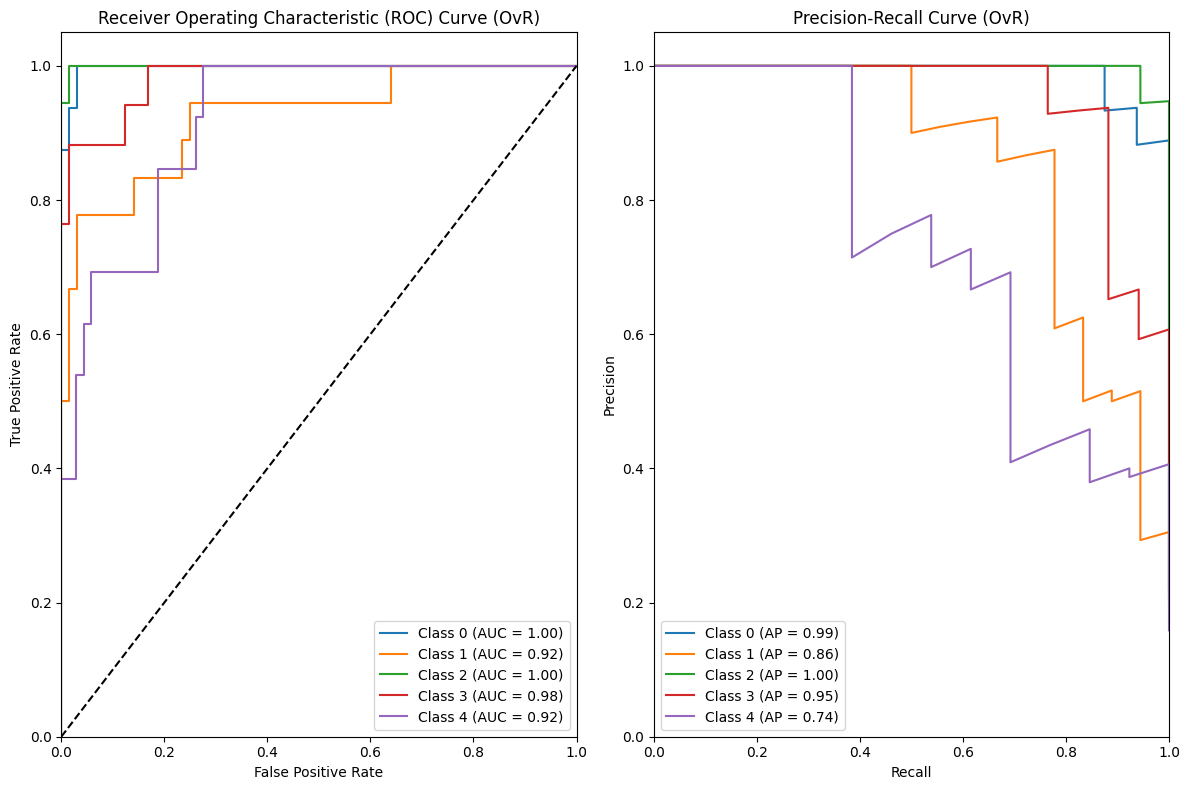


--- Evaluation Metrics per Class (OvR) ---
Class 0: AUC = 1.00, AP = 0.99
Class 1: AUC = 0.92, AP = 0.86
Class 2: AUC = 1.00, AP = 1.00
Class 3: AUC = 0.98, AP = 0.95
Class 4: AUC = 0.92, AP = 0.74


In [ ]:
# Plot ROC curve and Precision-Recall curve for each class
plt.figure(figsize=(12, 8))

for i in range(n_classes):
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label='Class {0} (AUC = {1:.2f})'.format(i, roc_auc))

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    average_precision = average_precision_score(y_test_bin[:, i], y_score[:, i])
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label='Class {0} (AP = {1:.2f})'.format(i, average_precision))

plt.subplot(1, 2, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (OvR)')
plt.legend(loc="lower right")

plt.subplot(1, 2, 2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (OvR)')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()

# Print AUC and AP for each class
print("\n--- Evaluation Metrics per Class (OvR) ---")
for i in range(n_classes):
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    average_precision = average_precision_score(y_test_bin[:, i], y_score[:, i])

    print('Class {0}: AUC = {1:.2f}, AP = {2:.2f}'.format(i, roc_auc, average_precision))

## Visualisasi hasil

### Subtask:
Visualisasikan hasil prediksi dan matriks kebingungan untuk memahami performa model pada setiap kelas.


**Reasoning**:
Visualize the confusion matrix to understand the model's performance per class.



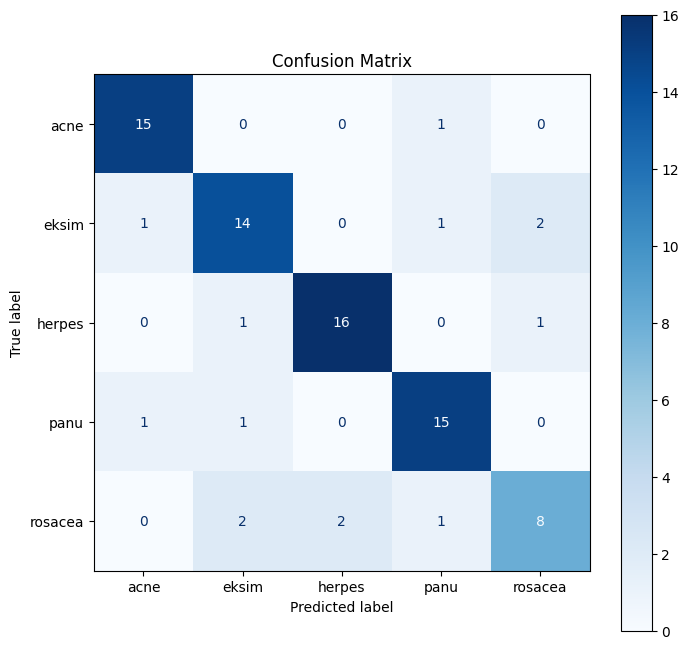

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Get the class names from the training data generator
class_names = list(train_data.class_indices.keys())

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_best_svm)

# Create a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_title('Confusion Matrix')
plt.show()

# Create a DataFrame of true vs predicted labels (optional, for further analysis)
results_df = pd.DataFrame({'True_Label': y_test, 'Predicted_Label': y_pred_best_svm})

## Summary:

### Data Analysis Key Findings

*   Image data augmentation parameters were adjusted, including increased rotation, shift, shear, and zoom ranges, changing the fill mode to 'reflect', and adding brightness augmentation.
*   Gray Level Co-occurrence Matrix (GLCM) feature extraction was implemented and combined with existing HOG and MobileNetV2 features.
*   Feature selection using `SelectKBest` with `f_classif` was performed on the combined features, and exploring different `k` values showed that selecting $k=75$ features provided a good balance between the number of features and classification accuracy.
*   Evaluation of different classification models revealed that the Support Vector Machine (SVM) model achieved a slightly higher accuracy (approximately 0.829) on the test set compared to the Random Forest model (approximately 0.817).
*   5-fold cross-validation showed that the SVM model had a mean cross-validation accuracy of approximately 0.826 with a standard deviation of 0.036, while the Random Forest model had a mean accuracy of approximately 0.794 with a standard deviation of 0.054.
*   Hyperparameter tuning using `GridSearchCV` identified the best hyperparameters for the SVM model as `{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}`, resulting in a best cross-validation accuracy of approximately 0.826.
*   Detailed evaluation metrics per class using the One-vs-Rest (OvR) strategy showed varying performance across classes, with some classes (e.g., Class 0 and 2) having high AUC and AP scores (near 1.00) and others (e.g., Class 4) having slightly lower scores (AUC=0.92, AP=0.74).
*   Visualization of the confusion matrix provided a clear view of the model's performance on each class, showing true positives, false positives, and false negatives.

### Insights or Next Steps

*   While SVM with optimized hyperparameters performed well, the varying per-class performance suggests further investigation into improving classification for specific classes with lower evaluation scores.
*   Explore advanced techniques such as ensemble methods or deep learning models directly trained on the image data to potentially achieve higher accuracy.


In [ ]:
import joblib

# Simpan model SVM terbaik ke dalam file
joblib.dump(best_svm_model, 'model_kondisi_kulit.pkl')
print("Model SVM terbaik telah disimpan.")

Model SVM terbaik telah disimpan.
